## Checking overlap of TF binding loci with eQTL SNPs from Karl's data.

1. Modelling each sequence context as having a probability of a eQTL SNPs that is given by a beta-binomial model out of N SNPs, x are eQTL SNPs in the sequence context for TF binding loci and control regions. 
2. Plot the distribution of probabilities.  
3. Check differences in enrichment between regions

In [1]:
%matplotlib inline 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib import rc

from scipy.special import gammaln
from scipy.stats import beta
from collections import deque
from Ranger import RangeSet, Range
from pybedtools import BedTool
from scipy.stats import scoreatpercentile
import cPickle

import numpy as np
import pandas as pd
import networkx as nx
import tables
import re
import os
import sqlite3
from __future__ import division

### Helper functions

In [2]:
def draw_violin(ax, xgrid, pdf, center_pt, width, cutoff=0.001, **kwargs):
    # Normalize pdf
    pdf /= np.max(pdf)
    # Get where the pdf is greater than the cutoff
    plot_pts = np.where(pdf >= cutoff)[0]
    ax.fill_betweenx(xgrid[plot_pts],center_pt-pdf[plot_pts]*width*0.5,
                      center_pt+pdf[plot_pts]*width*0.5,
                      **kwargs)

### Loading data
* snps positions (obtained from Karl Kremling, uplifted from v3 to v4 and Minimun read count = 5)
* leading eQTLs positions (obtained from Karl Kremling)
* analysis graph (already with counts of eqtls and snps)

In [3]:
## Load the graph from a pickle file 
## To avoid having to run the whole analysis each time that I need the figure
wdir = '/Users/mm2842/p_transcriptionfactors/Figures/Data/'
analysis_graphs = cPickle.load(open(os.path.join(wdir,'binding_loci_stepwise_graph.pkl'),'r'))

In [13]:
## Run this cell, only if an enrichment test using the population of SNPs as a background will be considered
population_size = 33368753
population_hits = 30915
population_failure = 33337838
sample_hits = analysis_graphs['union'].node['m1a']['eqtl']
sample_size = analysis_graphs['union'].node['m1a']['non-eqtl'] + analysis_graphs['union'].node['m1a']['eqtl']            

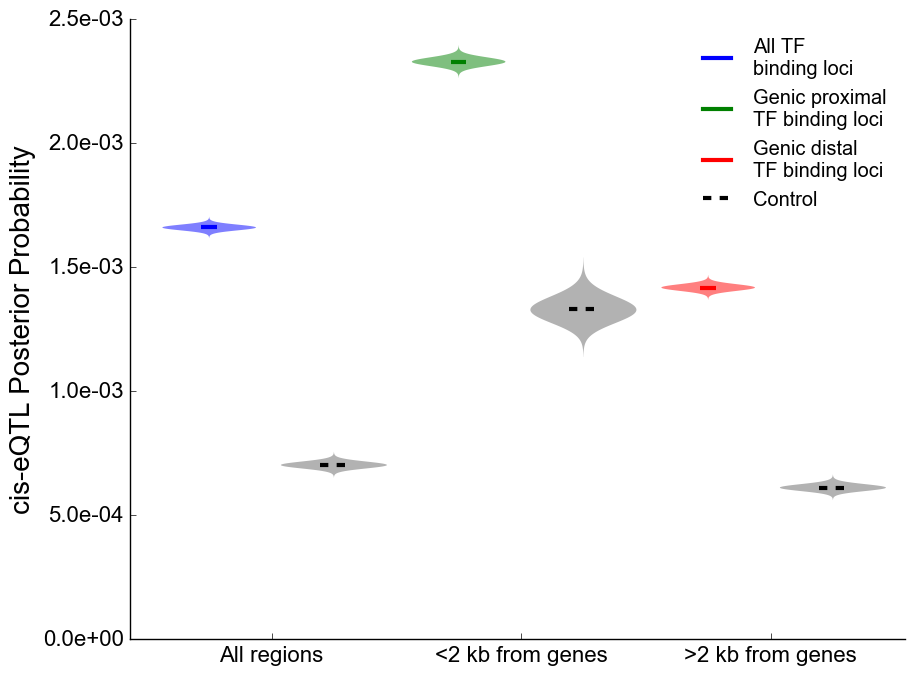

In [4]:
a=1
b=1
width = 0.85
min_pt = 0.
max_pt = 0.0070
xgrid = np.linspace(min_pt,max_pt,10000) #10000

comparisons = [('m1a','m1b','All TF\nbinding loci'),
               ('m2a','m2c','Genic proximal\nTF binding loci'),
               ('m2b','m2d','Genic distal \nTF binding loci')]

plt.close()

plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial'],'size':12})
max_pt = 0.0025
min_pt = 0.
fig = plt.figure(facecolor='White',figsize=(10,8))
ax = fig.add_subplot(111) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

wdir = '/Users/mm2842/Desktop/'
colors=['b','g','r']
labels=['All binding loci', 'Genic proximal','Genic distal']
for contrast,(hot_node,ctrl_node,seq_type) in enumerate(comparisons):
    i = 0
    for tissue in ('union',):   
        i = i + contrast
        if contrast <= 2:
            center_v1=2*i+width/2.
            pos_start_mean= (2*i+width/4.)+0.15
            pos_end_mean= (2*i+3*width/4.)-0.15
            draw_violin(ax, xgrid, beta.pdf(xgrid, analysis_graphs[tissue].node[hot_node]['eqtl']+a,
                                    analysis_graphs[tissue].node[hot_node]['non-eqtl']+b),
                                    center_v1, width=0.75, color='White',facecolor=colors[contrast],linewidth=1,
                                    alpha=0.5, edgecolor='none')  
            plt.hlines(beta.mean(analysis_graphs[tissue].node[hot_node]['eqtl']+a,
                             analysis_graphs[tissue].node[hot_node]['non-eqtl']+b),
                        pos_start_mean, pos_end_mean,
                        color=colors[contrast], linewidth=3, label=seq_type,linestyles='-')
        else:
            plt.hlines(beta.mean(analysis_graphs[tissue].node[hot_node]['eqtl']+a,
                             analysis_graphs[tissue].node[hot_node]['non-eqtl']+b),
                        pos_start_mean, pos_end_mean,
                        color=colors[contrast], linewidth=3, linestyles='-')
            
        
        if contrast <= 2:
            center_v2=2*i+1+width/2.    
            pos_start_mean_v2= (2*i+1+width/2.-width/4.)+0.10
            pos_end_mean_v2= (2*i+1+width/2.+width/4.)-0.10
            
            draw_violin(ax, xgrid, beta.pdf(xgrid, analysis_graphs[tissue].node[ctrl_node]['eqtl']+a,
                                    analysis_graphs[tissue].node[ctrl_node]['non-eqtl']+b),
                                    center_v2,
                                    width=width,color='White',facecolor='k',linewidth=1,
                                    alpha=0.3, edgecolor='none')
        if contrast == 2:
            plt.hlines(beta.mean(analysis_graphs[tissue].node[ctrl_node]['eqtl']+a,
                             analysis_graphs[tissue].node[ctrl_node]['non-eqtl']+b),
                        pos_start_mean_v2, pos_end_mean_v2,
                        color='k', linewidth=3, label='Control',linestyle='dashed')
        else:
            plt.hlines(beta.mean(analysis_graphs[tissue].node[ctrl_node]['eqtl']+a,
                             analysis_graphs[tissue].node[ctrl_node]['non-eqtl']+b),
                        pos_start_mean_v2, pos_end_mean_v2,
                        color='k', linewidth=3, linestyle='dashed')


plt.xticks(np.arange(0,8,2)+width+(1.-width)/2.,
           ['All regions','<2 kb from genes','>2 kb from genes'])
plt.ylabel('cis-eQTL Posterior Probability',fontsize=20)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.tick_params(top='off', bottom='on', left='on', right='off',which='major',labelsize=16)
plt.tick_params(axis='both',which='minor',labelsize=16)
plt.xlim([-width/4.,2*i+2])
plt.ylim([min_pt,max_pt])
plt.legend(loc='best',frameon=False)

In [12]:
# Differentiate between TF binding locid and control        
sim_ACRs = beta.rvs(analysis_graphs['union'].node['m1a']['eqtl']+1,
                     analysis_graphs['union'].node['m1a']['non-eqtl']+1,
                     size=100000)
sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m1b']['eqtl']+1,
                     analysis_graphs['union'].node['m1b']['non-eqtl']+1,
                     size=100000)

print 'Enrichment - TF binding loci vs control'
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5), scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50)


Enrichment - TF binding loci vs control
2.26517015596 2.46181352567
2.36109261516


In [13]:
# Differentiate between TF binding loci and control for genic proximal regions
sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2a']['eqtl']+1,
                     analysis_graphs['union'].node['m2a']['non-eqtl']+1,
                     size=100000)
sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2c']['eqtl']+1,
                     analysis_graphs['union'].node['m2c']['non-eqtl']+1,
                     size=100000)

print 'Enrichment - TF binding loci - proximal vs control'
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5), scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50)

Enrichment - TF binding loci - proximal vs control
1.61629933596 1.90120314187
1.75102314623


In [14]:
# Differentiate between TF binding loci and control for genic distal regions
sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2b']['eqtl']+1,
                     analysis_graphs['union'].node['m2b']['non-eqtl']+1,
                     size=100000)
sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2d']['eqtl']+1,
                     analysis_graphs['union'].node['m2d']['non-eqtl']+1,
                     size=100000)

print 'Enrichment - TF binding loci - distal vs control'
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5), scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50)


Enrichment - TF binding loci - distal vs control
2.20813431209 2.43324254498
2.317257914


In [15]:
sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2a']['eqtl']+1,
                     analysis_graphs['union'].node['m2a']['non-eqtl']+1,
                     size=100000)
sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2b']['eqtl']+1,
                     analysis_graphs['union'].node['m2b']['non-eqtl']+1,
                     size=100000)

print 'Enrichment - TF binding loci - proximal vs distal'
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5), scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50)

Enrichment - TF binding loci - proximal vs distal
1.60265675831 1.68188889867
1.64167473745
